**IMPORT LIBRARIES/DATASET**

In [ ]:
# Import required library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
import boto3
from sklearn.preprocessing import StandardScaler, LabelEncoder
from datetime import datetime
import io

In [2]:

#Ignore warnings
warnings.filterwarnings("ignore")

# Get today's date in YYYY-MM-DD format
current_date = datetime.today().strftime('%Y-%m-%d')

# AWS S3 Configurations
BUCKET_NAME = "telco-churn-data1"
FILE_KEY = f"raw/{current_date}/telco_customer_churn.csv"  # Adjust the path inside the bucket


# Initialize S3 Client
s3 = boto3.client("s3")

# Download Data from S3
response = s3.get_object(Bucket=BUCKET_NAME, Key=FILE_KEY)
data = pd.read_csv(io.BytesIO(response["Body"].read()))

In [3]:
# Display the first 2 rows
data.head(2)

,customerid,gender,seniorcitizen,partner,dependents,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,...,techsupport,streamingtv,streamingmovies,tenure,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,No,No phone service,DSL,No,Yes,...,No,No,No,1,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,Yes,No,DSL,Yes,No,...,No,No,No,34,One year,No,Mailed check,56.95,1889.5,No


**DATA PREPROCESSING**

1. Missing Values 

In [4]:
# Identify categorical and numerical columns
categorical_cols1 = ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines', 
                     'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
                     'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'churn']

numeric_cols1 = ['tenure', 'monthlycharges', 'customerid', 'totalcharges']

# Convert column names to lowercase to match the actual column names in the dataframe
data.columns = data.columns.str.lower()

# Convert categorical column names to lowercase to match the dataframe
categorical_cols1 = [col.lower() for col in categorical_cols1]

# Replace missing values in categorical columns with "No"
data[categorical_cols1] = data[categorical_cols1].fillna("No")

# Handle binary (0/1) columns separately
binary_cols = [col for col in categorical_cols1 if data[col].dropna().isin([0, 1]).all()]

# Fill missing values in binary columns with 0 (assuming 0 = No)
data[binary_cols] = data[binary_cols].fillna(0)

# Drop rows with missing values in other numerical columns
data = data.dropna(subset=[col for col in numeric_cols1 if col not in binary_cols])

# Print missing values count after handling
print("Missing values after handling:\n", data.isnull().sum())


Missing values after handling:
 customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
tenure              0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64


* To handle missing values in categorical columns, the code replaces any NaN values with "No", ensuring consistency in categorical data representation. Next, it identifies binary categorical columns—those that contain only 0 and 1—by checking if all non-null values in the column belong to this set. Missing values in these binary columns are then filled with 0, assuming that 0 represents the absence of a characteristic (e.g., "No" in a Yes/No scenario).
* For numerical columns, instead of filling missing values, the code drops any rows where non-binary numerical columns contain NaN, preventing potential biases or errors in numerical analysis.

2. Rectifying data-types

In [5]:
expected_types = {
    "customerid": "object",
    "gender": "object",
    "seniorcitizen": "int64",
    "partner": "object",
    "dependents": "object",
    "tenure": "int64",
    "phoneservice": "object",
    "multiplelines": "object",
    "internetservice": "object",
    "onlinesecurity": "object",
    "onlinebackup": "object",
    "deviceprotection": "object",
    "techsupport": "object",
    "streamingtv": "object",
    "streamingmovies": "object",
    "contract": "object",
    "paperlessbilling": "object",
    "paymentmethod": "object",
    "monthlycharges": "float64",
    "totalcharges": "float64",
    "churn": "object"
}
for col, expected_type in expected_types.items():
    actual_type = str(data[col].dtype)
    if actual_type != expected_type:
        if expected_type == "int64":
            data[col] = pd.to_numeric(data[col], errors="coerce").astype("Int64")
            print(f"Column {col} is converted into int64 data-type")
        elif expected_type == "float64":
            data[col] = pd.to_numeric(data[col], errors="coerce")
            print(f"Column {col} is converted into float64 data-type")
        elif expected_type == "object":
            print(f"Column {col} is converted object int64 data-type")
            data[col] = data[col].astype(str) 

Column totalcharges is converted into float64 data-type


Ensures that each column in the dataset has the correct data type as defined in the expected_types dictionary.

3. Removing duplicate values

In [6]:
data = data.drop_duplicates(subset="customerid", keep="first")

Removes duplicate rows in the dataset based on the "customerID" column, keeping only the first occurrence of each unique customer ID. It ensures that each customer appears only once in the dataset, preventing redundant entries that could skew analysis or model training.

4. Convert all categorical values to lowercase

In [7]:
categorical_cols2 = cols = ['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 
        'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 
        'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'churn']

data[categorical_cols2] = data[categorical_cols2].apply(lambda col: col.str.lower())

Converts all values in the specified categorical columns to lowercase. It ensures consistency in text formatting, making the data uniform and reducing the risk of mismatches due to case differences.

5. Handling Range value

In [8]:
data["tenure"] = data["tenure"].clip(lower=0, upper=100)

Ensures that values in the "tenure" column are within the range of 0 to 100

**DATA VISUALIZATION**

1. Histograms for all numeric features

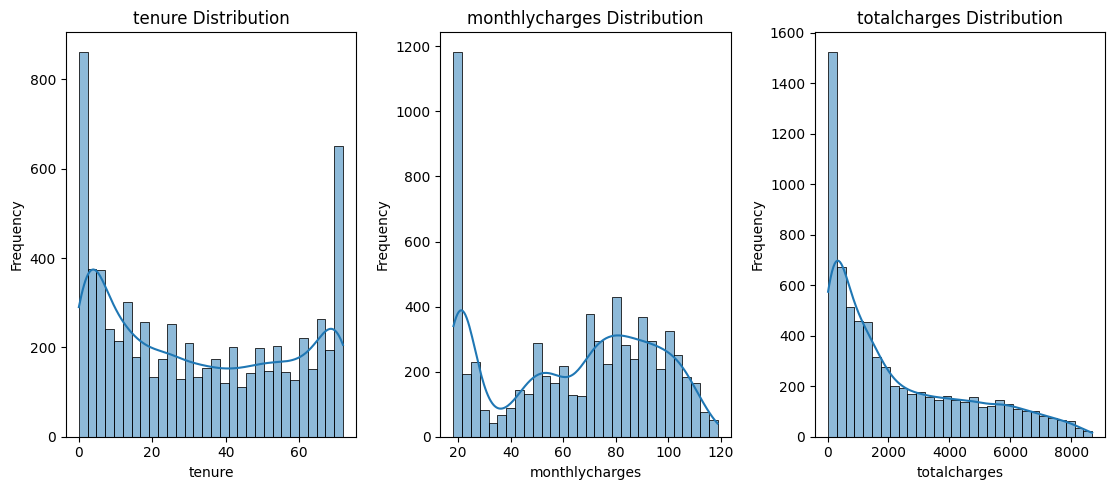

In [9]:
numeric_cols2 = ['tenure', 'monthlycharges', 'totalcharges']

num_numeric = len(numeric_cols2)
rows = math.ceil(num_numeric / 4)
plt.figure(figsize=(15, 5 * rows))
for i, col in enumerate(numeric_cols2, 1):
    plt.subplot(rows, 4, i)
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

* Tenure Distribution
    * The tenure variable represents how long a customer has stayed with the company.
    * The distribution is bimodal, meaning it has two peaks.
        * One peak is at 0-5 months, indicating a significant number of customers leave early.
        * Another peak is at 60+ months, showing some customers remain loyal for a long time.
    * The pattern suggests that customers either churn quickly or stay for an extended period, which might be related to contract type or satisfaction levels.

* Monthly Charges Distribution
    * MonthlyCharges represents how much a customer pays per month.
    * The distribution is right-skewed, meaning most customers have relatively low monthly charges, but some have significantly higher bills.
    * A spike is seen around $20–$30, possibly indicating a popular entry-level plan.
    * There is a gradual decline, suggesting some customers opt for premium services, but fewer do as prices increase.

* Total Charges Distribution
    * TotalCharges represents the cumulative amount a customer has paid.
    * The distribution is highly right-skewed, with many customers having low total charges (due to short tenure).
    * Some customers have very high total charges, likely those who have stayed for years and subscribed to higher-tier services.

2. Boxplots for all numeric features

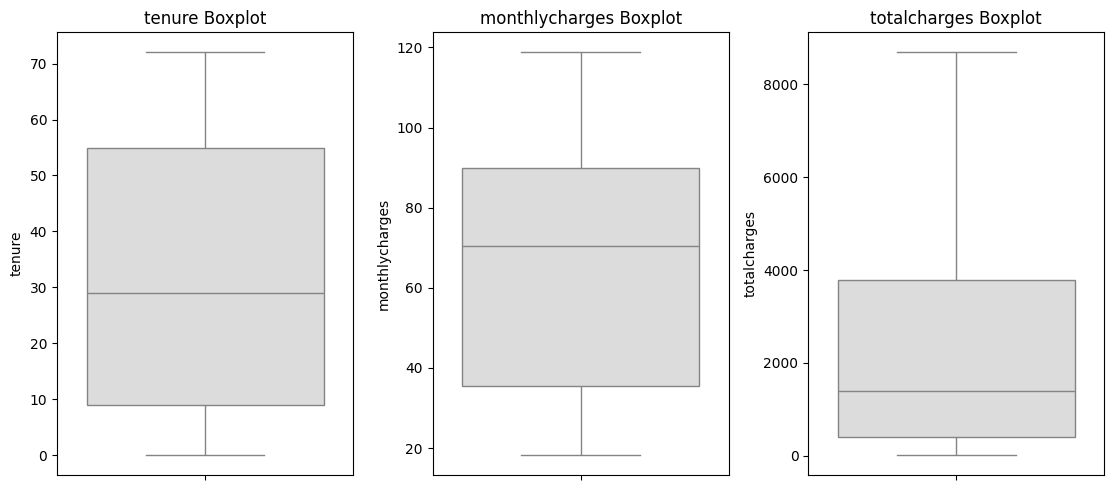

In [10]:
plt.figure(figsize=(15, 5 * rows))
for i, col in enumerate(numeric_cols2, 1):
    plt.subplot(rows, 4, i)
    sns.boxplot(y=data[col], palette='coolwarm')
    plt.title(f'{col} Boxplot')
plt.tight_layout()
plt.show()

* Tenure Boxplot
    * The median tenure is around 30 months.
    * The interquartile range (IQR) spans from near 10 to 60 months, meaning most customers fall in this range.

* Monthly Charges Boxplot
    * The median is around $70.
    * The data distribution is spread out, with some customers paying as little as $20 and others exceeding $100.

* Total Charges Boxplot
    * The median total charge is relatively low due to many short-term customers.
    * A long upper whisker suggests that a few customers have very high total charges.

3. Countplots for categorical features

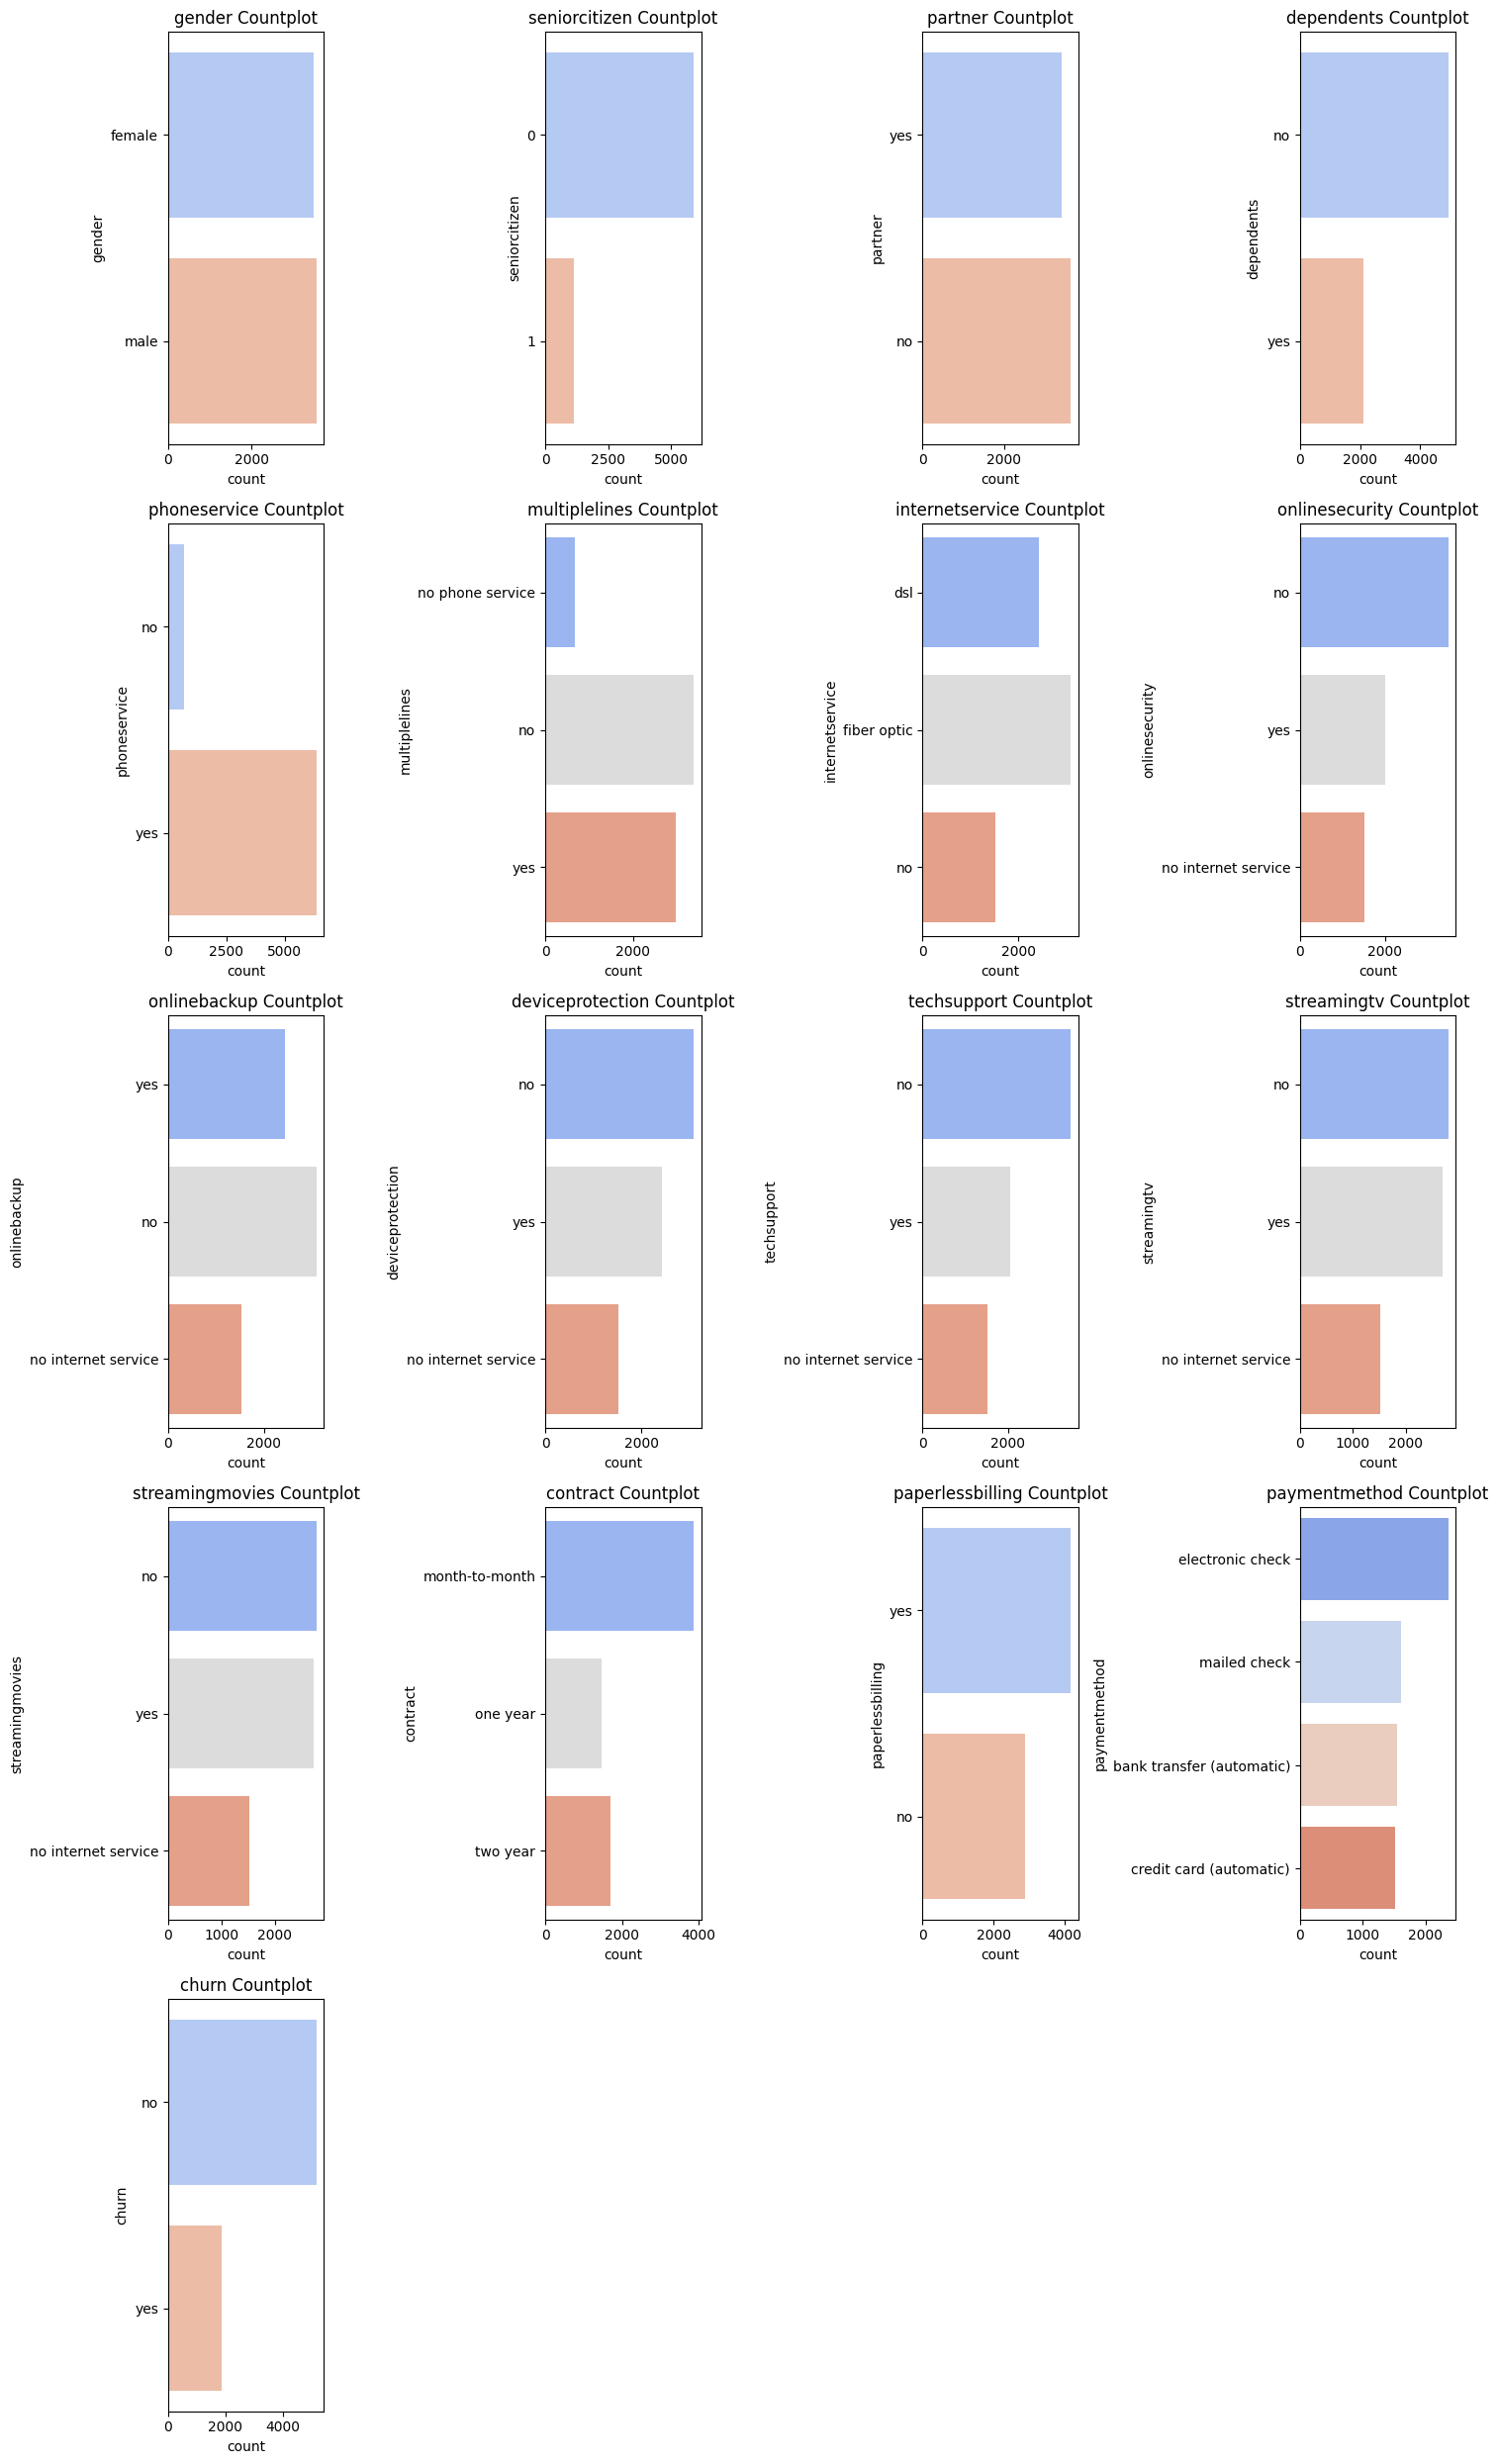

In [11]:
num_categorical = len(categorical_cols1)
rows = math.ceil(num_categorical / 4)
plt.figure(figsize=(15, 5 * rows))
for i, col in enumerate(categorical_cols1, 1):
    plt.subplot(rows, 4, i)
    sns.countplot(y=data[col], palette='coolwarm')
    plt.title(f'{col} Countplot')
plt.tight_layout()
plt.show()

* Gender Count Plot
    * The distribution of male and female customers is almost equal, meaning gender does not have a strong influence on churn or services.

* Senior Citizen Count Plot
    * Most customers are not Senior Citizens (represented by 0).
    * A smaller portion of customers are Senior Citizens (1), suggesting this group might have unique service preferences or churn behavior.

* Partner & Dependents Count Plots
    * More customers have a partner than those who don’t.
    * A majority of customers do not have dependents, which might indicate a working-age customer base.

* Phone & Internet Service Count Plots
    * The majority of customers have phone service, but MultipleLines varies, with a good proportion having single-line service.
    * InternetService is split among DSL, Fiber Optic, and No Service, with fiber optic being the most popular.

* Online Security, Backup, and Streaming Services Count Plots
    * Many customers do not have online security, backup, or device protection.
    * Streaming services are also split, with some customers actively subscribing while others do not.

* Contract, Paperless Billing, and Payment Method Count Plots
    * A significant number of customers have month-to-month contracts, while fewer have one-year or two-year contracts.
    * Many customers prefer paperless billing, indicating a tech-savvy user base.
    * Electronic checks seem to be a common payment method, which could be linked to churn risk.

* Churn Count Plot
    * There are more customers who did not churn than those who did.
    * However, a significant portion of customers did churn, highlighting the need to identify the factors driving churn.

4. Correlation Heatmap

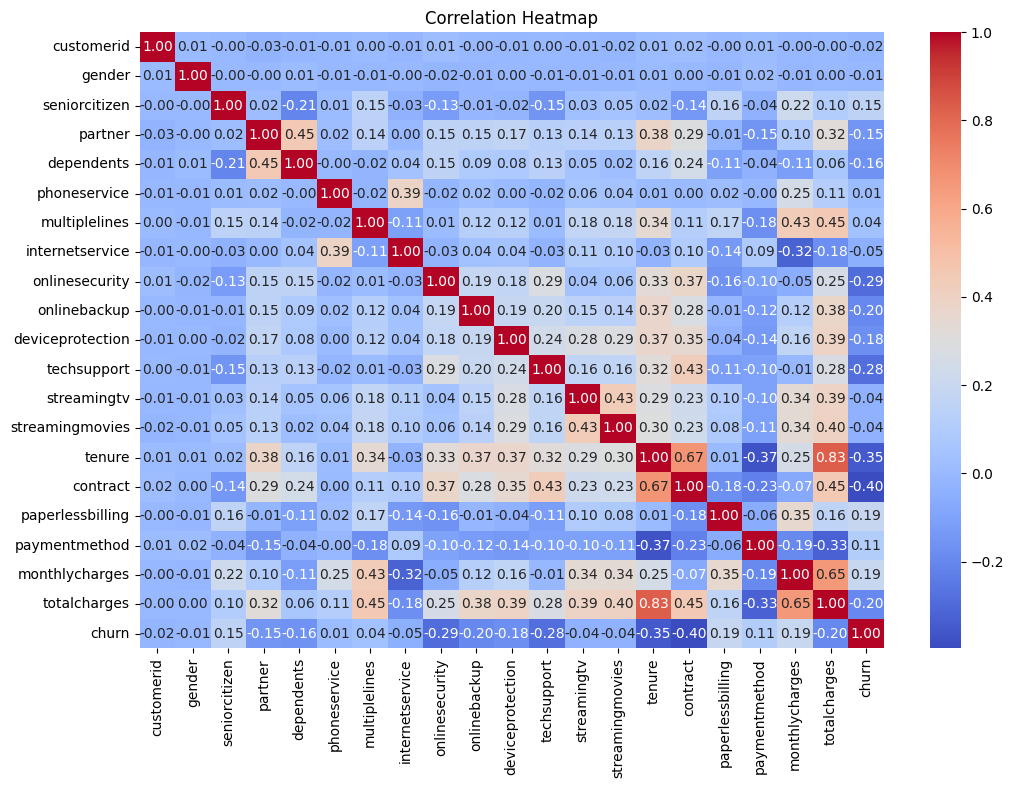

In [12]:
data1 = data.copy()
# Encoding categorical features
label_encoders = {}
for col in data1.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data1[col] = le.fit_transform(data1[col])
    label_encoders[col] = le

# Feature Engineering
scaler = StandardScaler()
data1[numeric_cols2] = scaler.fit_transform(data1[numeric_cols2])

# Correlation Analysis
plt.figure(figsize=(12,8))
corr_matrix = data1.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

* TotalCharges and tenure are strongly correlated (~0.83), meaning longer tenure naturally leads to higher total charges.
* Contract is moderately correlated with tenure, suggesting that customers on longer contracts tend to stay longer.
* MonthlyCharges has a weaker correlation with TotalCharges than expected, possibly due to variations in tenure.
* Churn has a negative correlation with tenure (~-0.35), meaning customers who stay longer are less likely to churn.
* Other features show relatively weak correlations, suggesting that churn is influenced by multiple factors rather than a single variable.


In [ ]:
# Drop customerid column
data.drop(columns='customerid', inplace=True)

* Identifying and droping the rows having High Correlation. Also ensuring that only one feature from each highly correlated pair remains in the dataset.
* Here, features with a correlation above 0.80 are removed.
* Since Customer ID is unique and does not impact churn, it is being removed from the dataset.

**FEATURE ENGINEERING**

In [ ]:
# Label Encoding for binary categorical columns
binary_cols = ['gender', 'partner', 'dependents', 'phoneservice', 'paperlessbilling', 'churn', 'internetservice', 'contract', 'paymentmethod', 'multiplelines', 'onlinesecurity', 
        'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies']
le = LabelEncoder()
for col in binary_cols:
    data[col] = le.fit_transform(data[col])


In [ ]:
# Standardizing numerical columns
scaler = StandardScaler()
data[['totalcharges']] = scaler.fit_transform(data[['totalcharges']])

Feature Engineering techniques applied
1. One-Hot Encoding for Nominal Variables:For categorical variables with more than two unique values ('InternetService', 'Contract', 'PaymentMethod'), One-Hot Encoding is applied.Using pd.get_dummies() creates binary (dummy) variables for each category, and drop_first=True avoids the dummy variable trap by removing one redundant column.
2. Label Encoding (LabelEncoder):For binary categorical variables like 'gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn', Label Encoding is applied..
3. Standard Scaling (StandardScaler) for Most Numeric Features: Applied to ['tenure', 'MonthlyCharges']. Standardizes features to have a mean of 0 and a standard deviation of 1.
4. Binning tenure into Groups: here tenure has been divided into bins (Unknown: Negative values (possibly missing data or incorrect entries), New: Exactly 0 months tenure, Very Short: 1 month, Short: 1–5 months, Medium: 5–10 months, Long: More than 10 months).It basically helps in capturing non-linear relationships between tenure and fraud risk. After making bins One-Hot Encoding has been applied.

In [16]:
#NOTE: to change path
data.to_csv("clean_dataset.csv", index=False, mode="w")